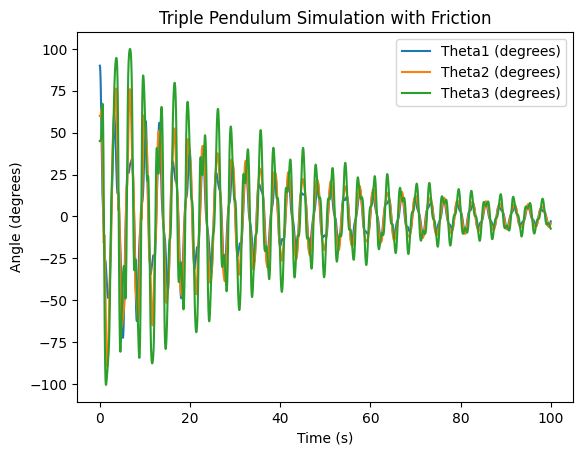

In [1]:
from __future__ import division, print_function
from math import sin, cos, pi, radians, degrees
import numpy as np
import matplotlib.pyplot as plt
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

# Physical constants
g = 9.81  # Acceleration due to gravity (m/s^2)
l1 = 1.0  # Length of the first pendulum (m)
l2 = 1.0  # Length of the second pendulum (m)
l3 = 1.0  # Length of the third pendulum (m)
m1 = 1.0  # Mass of the first pendulum (kg)
m2 = 1.0  # Mass of the second pendulum (kg)
m3 = 1.0  # Mass of the third pendulum (kg)

# Friction/damping coefficients
damping1 = 0.05  # Damping for the first pendulum
damping2 = 0.05  # Damping for the second pendulum
damping3 = 0.05  # Damping for the third pendulum

def f(q, t):
    '''Triple Pendulum equation of motion with friction'''
    theta1, omega1, theta2, omega2, theta3, omega3 = q

    # Useful constants
    m12 = m2 + m3
    m012 = m1 + m2 + m3
    mf = m012 / 4

    # Useful sines and cosines
    sin0 = sin(theta1)
    sin1 = sin(theta2)
    sin2 = sin(theta3)
    cos01 = cos(theta1 - theta2)
    cos02 = cos(theta1 - theta3)
    cos12 = cos(theta2 - theta3)
    sin01 = sin(theta1 - theta2)
    sin02 = sin(theta1 - theta3)
    sin12 = sin(theta2 - theta3)

    # Recurrent patterns
    r1 = m12 * cos01 * cos02 - m012 * cos12
    r2 = m012 - m12 * cos01**2
    r3 = -m012 + m3 * cos02**2

    # Parts of the first equation
    od1_1 = 4 * m3 * m12
    od1_2 = r1 * cos01 + r2 * cos02
    od1_3 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od1_4 = (-g * (m2 + m3) * sin1
             + l1 * (m2 + m3) * sin01 * omega1**2
             - l3 * m3 * sin12 * omega3**2)
    od1_5 = -m3 * m12 * (cos02 - cos(theta1 - 2 * theta2 + theta3))**2 * m012
    od1_6 = (g * m012 * sin0
             + l2 * m12 * sin01 * omega2**2
             + l3 * m3 * sin02 * omega3**2)
    od1_7 = m3 * r1**2 + m12 * r3 * r2

    # Parts of the second equation
    od2_1 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od2_2 = g * m012 * sin0 + l2 * m12 * sin01 * omega2**2 + l3 * m3 * sin02 * omega3**2
    od2_3 = -g * (m2 + m3) * sin1 + l1 * (m2 + m3) * sin01 * omega1**2 - l3 * m3 * sin12 * omega3**2

    # Parts of the third equation
    od3_1 = g * m012 * sin0 + l2 * m12 * sin01 * omega2**2 + l3 * m3 * sin02 * omega3**2
    od3_2 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od3_3 = g * (m2 + m3) * sin1 - l1 * (m2 + m3) * sin01 * omega1**2 + l3 * m3 * sin12 * omega3**2

    # ThetaDot equations
    td1 = omega1
    td2 = omega2
    td3 = omega3

    # OmegaDot equations
    od1 = (mf * (od1_1 * od1_2 * od1_3 * r2
           - 4 * (-m3 * od1_2 * r1
                  + (m3 * r1**2 + m12 * r3 * r2) * cos01) * od1_4
           - (od1_5 + 4 * m3 * r1**2 + 4 * m12 * r3 * r2) * od1_6)
           / (l1 * od1_7 * m012 * r2)) - damping1 * omega1

    od2 = ((-m3 * r1 * m012 * od2_1 * r2
           - (m3 * (r1 * cos01 + r2 * cos02) * r1
              - (m3 * r1**2 + m12 * r3 * r2) * cos01) * od2_2
           + m012 * r3 * r2 * od2_3)
           / (l2 * od1_7 * r2)) - damping2 * omega2

    od3 = (-(m12 * od1_2 * od3_1
           + m12 * m012 * od3_2 * r2
           - r1 * m012 * od3_3)
           / (l3 * (m3 * r1**2 + m12 * r3 * r2))) - damping3 * omega3

    return array([td1, od1, td2, od2, td3, od3], float)

# Simulation parameters
a = 0.0  # Start time
b = 100.0  # End time
N = 10000  # Number of time steps
h = (b - a) / N  # Time step size

# Time points
tpoints = arange(a, b, h)

# Pre-allocate arrays for theta1, theta2, theta3
theta1_points = zeros_like(tpoints)
theta2_points = zeros_like(tpoints)
theta3_points = zeros_like(tpoints)

# Initial conditions in radians
initial_conditions = [pi / 2, 0, pi / 3, 0, pi / 4, 0]

# Convert initial conditions to radians
q = array(initial_conditions, float)

# Runge-Kutta 4th order method loop
for i, t in enumerate(tpoints):
    theta1_points[i] = degrees(q[0])  # Convert radians to degrees for plotting
    theta2_points[i] = degrees(q[2])  # Convert radians to degrees for plotting
    theta3_points[i] = degrees(q[4])  # Convert radians to degrees for plotting

    # RK4 coefficients
    k1 = h * f(q, t)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h)
    k4 = h * f(q + k3, t + h)

    # Update the state vector
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Plotting
plt.plot(tpoints, theta1_points, label='Theta1 (degrees)')
plt.plot(tpoints, theta2_points, label='Theta2 (degrees)')
plt.plot(tpoints, theta3_points, label='Theta3 (degrees)')
plt.title("Triple Pendulum Simulation with Friction")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.show()

In [10]:
data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
np.save('pendulum_data.npy', data)
data = np.load('pendulum_data.npy')

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Create the sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50
X, y = create_sequences(data, SEQ_LENGTH)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
# Define model class
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim * SEQ_LENGTH, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        seq_length = x.size(1)
        input_dim = x.size(2)
        x = x.view(batch_size, seq_length * input_dim)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [12]:
#initialize
input_dim = 3
hidden_dim = 64
output_dim = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedforwardNN(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#train loop
num_epochs = 100
patience = 10
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for data_val, targets_val in test_loader:
            data_val, targets_val = data_val.to(device), targets_val.to(device)
            outputs_val = model(data_val)
            loss_val = criterion(outputs_val, targets_val)
            val_loss += loss_val.item() * data_val.size(0)

    avg_val_loss = val_loss / len(test_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after epoch {epoch+1}')
            break

model.load_state_dict(torch.load('best_model.pth'))

model.eval()
predictions = []
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        predictions.append(outputs.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
y_test = y_test.cpu().numpy()

#calculate rmse and r^2
rmse = np.sqrt(np.mean((predictions - y_test)**2))
print(f'Test RMSE: {rmse:.6f}')

r2 = r2_score(y_test, predictions)
print(f'Test R^2 Score: {r2:.6f}')

Epoch [1/100], Train Loss: 0.012357, Val Loss: 0.000965
Epoch [2/100], Train Loss: 0.000545, Val Loss: 0.000348
Epoch [3/100], Train Loss: 0.000228, Val Loss: 0.000205
Epoch [4/100], Train Loss: 0.000139, Val Loss: 0.000134
Epoch [5/100], Train Loss: 0.000110, Val Loss: 0.000108
Epoch [6/100], Train Loss: 0.000091, Val Loss: 0.000114
Epoch [7/100], Train Loss: 0.000083, Val Loss: 0.000095
Epoch [8/100], Train Loss: 0.000072, Val Loss: 0.000072
Epoch [9/100], Train Loss: 0.000064, Val Loss: 0.000065
Epoch [10/100], Train Loss: 0.000058, Val Loss: 0.000064
Epoch [11/100], Train Loss: 0.000052, Val Loss: 0.000058
Epoch [12/100], Train Loss: 0.000049, Val Loss: 0.000051
Epoch [13/100], Train Loss: 0.000057, Val Loss: 0.000052
Epoch [14/100], Train Loss: 0.000045, Val Loss: 0.000064
Epoch [15/100], Train Loss: 0.000043, Val Loss: 0.000052
Epoch [16/100], Train Loss: 0.000041, Val Loss: 0.000067
Epoch [17/100], Train Loss: 0.000040, Val Loss: 0.000061
Epoch [18/100], Train Loss: 0.000042, Va

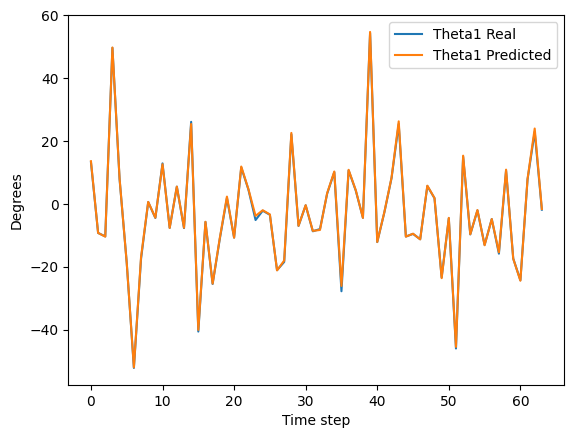

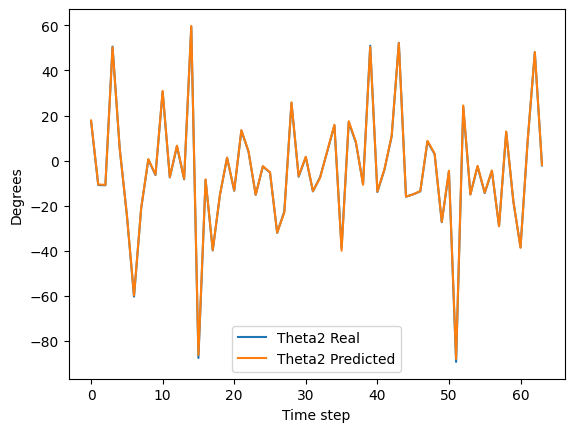

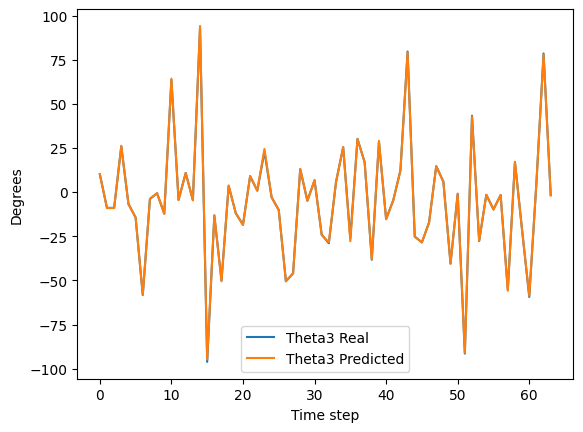

In [15]:
model.eval()
with torch.no_grad():
  for sequences, targets in test_loader:
    y_pred = model(sequences)
    break
  np_pred = y_pred.cpu().numpy()
  np_targets = targets.cpu().numpy()

  y_pred_ori = scaler.inverse_transform(np_pred)
  targets_ori = scaler.inverse_transform(np_targets)

  time_steps_to_plot = min(100, len(targets_ori))

plt.plot(targets_ori[:time_steps_to_plot, 0], label='Theta1 Real')
plt.plot(y_pred_ori[:time_steps_to_plot, 0], label='Theta1 Predicted')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()

plt.plot(targets_ori[:time_steps_to_plot, 1], label='Theta2 Real')
plt.plot(y_pred_ori[:time_steps_to_plot, 1], label='Theta2 Predicted')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()

plt.plot(targets_ori[:time_steps_to_plot, 2], label='Theta3 Real')
plt.plot(y_pred_ori[:time_steps_to_plot, 2], label='Theta3 Predicted')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()